In [36]:
#----------------------------------------------------------------------
# Importing all libraries needed
#----------------------------------------------------------------------

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

from librosa.filters import mel
from collections import Counter
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


time: 13.4 ms


In [37]:
#----------------------------------------------------------------------
# script to print execution time of each cell
#----------------------------------------------------------------------
%%capture

!pip install ipython-autotime

%load_ext autotime

time: 2.88 s


In [38]:
#----------------------------------------------------------------------
# Script to mount Google Drive
#----------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.7 ms


In [39]:
#----------------------------------------------------------------------
# Setting default Location and no of frames
#----------------------------------------------------------------------

default = '/content/drive/MyDrive/All_Data/'

folder = 'data_splits/Splitted_Data(5)/'
test_folder = 'test_task1/'

num_frames = 401

time: 4.03 ms


In [40]:
#----------------------------------------------------------------------
# Function to read Training files name and corresponding labels
#----------------------------------------------------------------------
def read_csv(filename):
    id_label = {}
    with open(filename,'r') as fid:
        for line in fid:
            tokens = line.strip().split(',')
            id_label[tokens[0]] = tokens[1]
    return id_label

time: 7.47 ms


In [41]:
#----------------------------------------------------------------------
# Making the mel transform matrix
#----------------------------------------------------------------------
n_mels = 513
n_fft = 1024
sr = 44100
mel = mel(sr = sr, n_fft = n_fft, n_mels = n_mels)
mel.shape

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(513, 513)

time: 16.4 ms


**Training Section**

In [ ]:
#----------------------------------------------------------------------
# Splitting the training data keeping the souces separated
#----------------------------------------------------------------------
data = read_csv(default + 'labels_train.csv')
data_set = pd.read_csv(default + 'labels_train.csv')
data_set = data_set.sample(frac=1).reset_index(drop=True)
X = data_set['slice_file_name']
Y = data_set['class']
Train={}
Val={}
is_Train= {}
X_Train = []
Y_Train = []
X_Val = []
Y_Val = []
for i in range(len(X)):
    temp_X = X[i]
    j = 0

    while (j<len(temp_X) and temp_X[j]!='-'):
        j+=1
    fs_id = temp_X[0:j]
    temp_label = data[temp_X]
    if (fs_id in Train):
        X_Train.append(temp_X)
        Y_Train.append(temp_label)
    elif (fs_id in Val):
        X_Val.append(temp_X)
        Y_Val.append(temp_label)
    elif (temp_label in is_Train):
        if (is_Train[temp_label]<2):
            X_Train.append(temp_X)
            Y_Train.append(temp_label)
            Train[fs_id] = 1
            is_Train[temp_label]+=1

        elif (len(X_Train)<(4.5)*len(X_Val)):
            X_Train.append(temp_X)
            Y_Train.append(temp_label)
            Train[fs_id] = 1
        else:
            X_Val.append(temp_X)
            Val[fs_id] = 1
            Y_Val.append(temp_label)
    else:
        X_Train.append(temp_X)
        Y_Train.append(temp_label)
        Train[fs_id] = 1
        is_Train[temp_label]=1
# print(len(X_Train))
# print(len(X_Val))
# print(len(Y_Train))
# print(len(Y_Val))

1434
327
1434
327
time: 51.6 ms


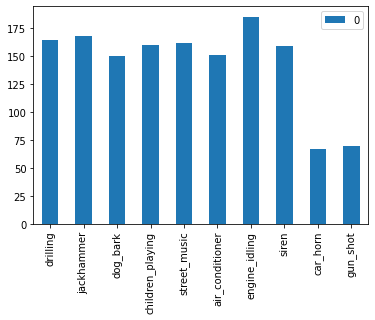

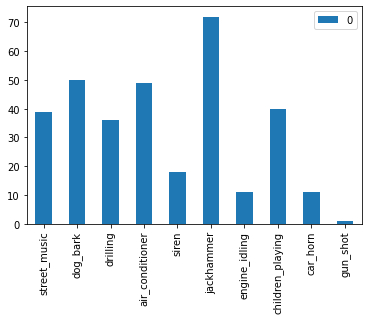

time: 398 ms


In [ ]:
#----------------------------------------------------------------------
# Plotting the Bar plots to see if the split is good enough
#----------------------------------------------------------------------

count1 = Counter(Ytrain)
df1 = pd.DataFrame.from_dict(count1, orient ='index')
df1.plot(kind='bar')

count2 = Counter(Yval)
df2 = pd.DataFrame.from_dict(count2, orient ='index')
df2.plot(kind='bar')

In [ ]:
#----------------------------------------------------------------------
# Converting the splitted data to dictionary format
#----------------------------------------------------------------------
data_train={}
data_val={}
for i in range(len(Xtrain)):
  data_train[Xtrain[i]]=Ytrain[i]
for i in range(len(Xval)):
  data_val[Xval[i]]=Yval[i]

time: 3.33 ms


In [ ]:
#----------------------------------------------------------------------
# Saving the Spliited Data in Dictionary Format
#----------------------------------------------------------------------
field_names= ['slice_file_name', 'label']

with open(default + folder + 'data_train.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in data_train.items():
       writer.writerow([key, value])

with open(default + folder + 'data_val.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in data_val.items():
       writer.writerow([key, value])

time: 18.6 ms


In [ ]:
#----------------------------------------------------------------------
# Loading the saved splitted data in dictinoary format
#----------------------------------------------------------------------

with open(default + folder + 'data_train.csv') as csv_file:
    reader = csv.reader(csv_file)
    data_train = dict(reader)

with open(default + folder + 'data_val.csv') as csv_file:
    reader = csv.reader(csv_file)
    data_val = dict(reader)

time: 15.5 ms


In [ ]:
#----------------------------------------------------------------------
# Organizing the training data and reshaping for further use
#----------------------------------------------------------------------

flag1=1 
flag2=1

for _ in data_train:
    if(flag1):
        
        a = _[0:-4]
        a = a + '.npy'
        
        temp_data_train = np.transpose(mel.dot(np.load(default + 'Training_data_1ch/' + a)))
        
        length = len(temp_data_train)
        num_pad = (num_frames - (length)%num_frames)%num_frames
        temp_data_train = np.pad(temp_data_train, [(0,num_pad),(0,0)])
        length = len(temp_data_train)
        
        if (flag2):
            X_train = np.reshape(temp_data_train, [length//num_frames, num_frames, temp_data_train.shape[1]])
            Y_train = np.vstack([data_train[_]]*(length//num_frames))
            train_labels = np.array([[length//num_frames, data_train[_]]])
        else:
            X_train = np.append(X_train, np.reshape(temp_data_train, [length//num_frames, num_frames, temp_data_train.shape[1]]), axis=0)
            Y_train = np.append(Y_train, np.vstack([data_train[_]]*(length//num_frames)), axis=0)
            train_labels = np.append(train_labels, np.array([[length//num_frames, data_train[_]]]), axis=0)
        flag2=0
    flag1=1

In [ ]:
#----------------------------------------------------------------------
# Saving the Training Data
#----------------------------------------------------------------------

print(X_train.shape)
print(Y_train.shape)
print(train_labels)

np.save(default + folder + 'melTrain(' + str(num_frames) +')/X_train', X_train)
np.save(default + folder + 'melTrain(' + str(num_frames) +')/Y_train', Y_train)
np.save(default + folder + 'melTrain(' + str(num_frames) +')/train_labels', train_labels)

In [7]:
#----------------------------------------------------------------------
# Loading the Training Data
#----------------------------------------------------------------------
X_train = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'X_train.npy')
Y_train = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'Y_train.npy')
train_labels = np.load(default + folder + 'melTrain(' + str(num_frames) +')/'+'train_labels.npy')

time: 30.9 s


In [8]:
#----------------------------------------------------------------------
# Organizing true labels to one hot vectors
#----------------------------------------------------------------------
encoder = LabelEncoder()
encoder.fit(Y_train.ravel())
np.save(default + 'classes.npy', encoder.classes_)

encoded_Y_train = encoder.transform(Y_train.ravel())
one_hot_Y_train = np_utils.to_categorical(encoded_Y_train)

labels = np.unique(encoded_Y_train)
n_feat = X_train.shape[2]

train_labels[:,1] = encoder.transform(train_labels[:,1])
train_labels = train_labels.astype('int')

time: 383 ms


In [ ]:
#----------------------------------------------------------------------
# Organizing the validation data and reshaping for further use
#----------------------------------------------------------------------
flag1=1
flag2=1

for _ in data_val:
    if(flag1):
        
        a = _[0:-4]
        a = a + '.npy'
        
        temp_data_val = np.transpose(mel.dot(np.load(default + 'Training_data_1ch/' + a)))
        
        length = len(temp_data_val)
        num_pad = (num_frames - (length)%num_frames)%num_frames
        temp_data_val = np.pad(temp_data_val, [(0,num_pad),(0,0)])
        length = len(temp_data_val)
        
        if (flag2):
            X_val = np.reshape(temp_data_val, [length//num_frames, num_frames, temp_data_val.shape[1]])
            Y_val = np.vstack([data_val[_]]*(length//num_frames))
            val_labels = np.array([[length//num_frames, data_val[_]]])
        else:
            X_val = np.append(X_val, np.reshape(temp_data_val, [length//num_frames, num_frames, temp_data_val.shape[1]]), axis=0)
            Y_val = np.append(Y_val, np.vstack([data_val[_]]*(length//num_frames)), axis=0)
            val_labels = np.append(val_labels, np.array([[length//num_frames, data_val[_]]]), axis=0)
        flag2=0
    flag1=1

In [ ]:
#----------------------------------------------------------------------
# Saving the Validation data
#----------------------------------------------------------------------
print(X_val.shape)
print(Y_val.shape)
print(val_labels.shape)

np.save(default + folder + 'melValidate(' + str(num_frames) +')/X_val', X_val)
np.save(default + folder + 'melValidate(' + str(num_frames) +')/Y_val', Y_val)
np.save(default + folder + 'melValidate(' + str(num_frames) +')/val_labels', val_labels)

In [9]:
#----------------------------------------------------------------------
# Loading the Validation data
#----------------------------------------------------------------------

X_val = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'X_val.npy')
Y_val = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'Y_val.npy')
val_labels = np.load(default + folder + 'melValidate(' + str(num_frames) +')/'+'val_labels.npy')

time: 5.93 s


In [10]:
#----------------------------------------------------------------------
# Organizing true labels to one hot vectors of validation data
#----------------------------------------------------------------------
encoded_Y_val = encoder.transform(Y_val.ravel())
one_hot_Y_val = np_utils.to_categorical(encoded_Y_val)

val_labels[:,1] = encoder.transform(val_labels[:,1])
val_labels = val_labels.astype('int')

time: 5.03 ms


**CNN**

In [11]:
#----------------------------------------------------------------------
# Reshaping the Data for cnn model
#----------------------------------------------------------------------
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
input_dim = (num_frames, n_feat, 1)
output_dim = one_hot_Y_train.shape[1]

seed(1)
tf.random.set_seed(2)

#----------------------------------------------------------------------
# Defining the cnn model
#----------------------------------------------------------------------
def cnn_model():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=(3,8),strides=(1,1),padding="Same",input_shape=input_dim, activation = 'relu',kernel_regularizer = l2(0.001)))
    model.add(Conv2D(32,kernel_size=(3,5),strides=(1,1),padding="same", kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (4,3), strides = (4,3)))
    

    model.add(Conv2D(64,kernel_size=(3,1),strides=(1,1),padding="Same",kernel_regularizer = l2(0.001)))
    model.add(Conv2D(64,kernel_size=(3,1),strides=(1,1),padding="same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (4,1), strides = (4,1)))

    model.add(Conv2D(128,kernel_size=(1,5),strides=(1,1),padding="Same",kernel_regularizer = l2(0.001)))
    model.add(Conv2D(128,kernel_size=(1,5),strides=(1,1),padding="same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D(pool_size = (1,3), strides = (1,3)))

    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.7))

    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(output_dim,activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model


time: 30.6 ms


In [14]:
#----------------------------------------------------------------------
# Calculating the model
#----------------------------------------------------------------------
estimator = cnn_model()
history = estimator.fit(X_train, one_hot_Y_train, validation_data = (X_val, one_hot_Y_val), epochs = 20, batch_size = 32)

Epoch 1/20
45/45 [==============================] - 19s 428ms/step - loss: 4.1323 - accuracy: 0.1512 - val_loss: 2.5527 - val_accuracy: 0.0644
Epoch 2/20
45/45 [==============================] - 19s 415ms/step - loss: 2.7072 - accuracy: 0.1805 - val_loss: 2.7098 - val_accuracy: 0.1564
Epoch 3/20
45/45 [==============================] - 18s 409ms/step - loss: 2.6103 - accuracy: 0.2014 - val_loss: 2.5853 - val_accuracy: 0.2025
Epoch 4/20
45/45 [==============================] - 18s 407ms/step - loss: 2.4357 - accuracy: 0.2669 - val_loss: 2.3553 - val_accuracy: 0.3313
Epoch 5/20
45/45 [==============================] - 18s 407ms/step - loss: 2.4481 - accuracy: 0.2941 - val_loss: 2.5276 - val_accuracy: 0.2025
Epoch 6/20
45/45 [==============================] - 18s 408ms/step - loss: 2.1925 - accuracy: 0.3436 - val_loss: 2.1817 - val_accuracy: 0.3620
Epoch 7/20
45/45 [==============================] - 18s 408ms/step - loss: 2.0825 - accuracy: 0.3805 - val_loss: 2.2650 - val_accuracy: 0.3834

**Check How Model Worked**

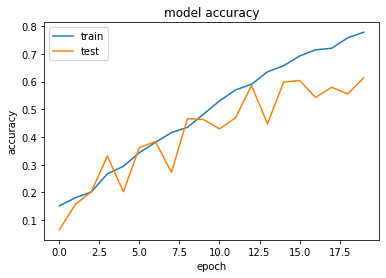

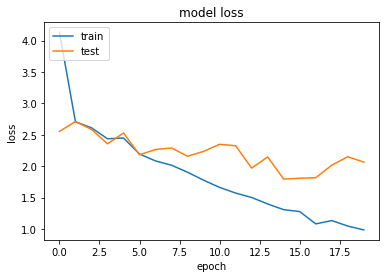

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 401, 513, 32)      800       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 401, 513, 32)      15392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 171, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 171, 64)      6208      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 171, 64)      12352     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 171, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 171, 128)     

In [15]:
#----------------------------------------------------------------------
# Plotting the history of the model and printing the model summary
#----------------------------------------------------------------------

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(default + folder + 'Plots6/Accuracy.png', dpi=800)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(default + folder + 'Plots6/Loss.png', dpi=800)
plt.show()

estimator.summary()

In [16]:
#----------------------------------------------------------------------
# Predicting labels of Validation set
#----------------------------------------------------------------------

predictions = estimator.predict_proba(X_val)

i=0
Y_true = val_labels[:,1]
Y_pred = np.zeros(val_labels[:,0].shape)
for j in range(len(val_labels)):
    index = val_labels[j][0]+i
    A = predictions[i:index, :]
    Y_pred[j]=(np.argmax(np.sum(A, axis=0)))
    i=index

Instructions for updating:
Please use `model.predict()` instead.
time: 1.39 s


In [17]:
#----------------------------------------------------------------------
# Outputting quantitaive metrics
#----------------------------------------------------------------------

CM = np.zeros((output_dim,output_dim))
for i in range(len(Y_pred)):
    CM[Y_true[i]][np.int(Y_pred[i])] += 1
print('Audio labels Result -> ')
print('Confusion Matrix ->')
print(CM)
print('Accuracy Score ->', accuracy_score(Y_true, Y_pred))
print('\n')

Audio labels Result -> 
Confusion Matrix ->
[[ 0.  0.  1.  0.  0. 14.  0. 12.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 16.  5.  2.  5.  0.  0.  0.  5.]
 [ 0.  0.  6. 41.  1.  5.  2.  0.  0.  0.]
 [ 0.  0.  1.  0. 35.  0.  0.  1.  1.  0.]
 [ 3.  0.  0.  0.  0. 30.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0. 18.  0.  0.  0.]
 [ 0.  0.  0.  0. 17.  4.  0. 21.  0.  0.]
 [ 7.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  1.  0. 19.  3.  0.  2.  3. 31.]]
Accuracy Score -> 0.6134969325153374


time: 6.49 ms


In [18]:
#----------------------------------------------------------------------
# Saving the trained model
#----------------------------------------------------------------------
estimator.save(default + folder + 'melModel(' + str(num_frames) + ')')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/All_Data/data_splits/Splitted_Data(5)/melModel(401)/assets
time: 4.62 s


**Testing Section**

In [42]:
#----------------------------------------------------------------------
# Generating a list of file names
#----------------------------------------------------------------------
data_test=[]
for i in range(1,51):
    if (i<10):
        a = 'a00' + str(i)
    else:
        a = 'a0' + str(i)
    data_test.append(a)

time: 3.73 ms


In [43]:
#----------------------------------------------------------------------
# Loading data of test_task1 and organizing it to test the model
#----------------------------------------------------------------------
# data_test = read_csv(default + test_folder + 'labels.csv')

flag2=1

for _ in data_test:
    if(_ == 'slice_file_name'):
        continue
    if (_[-3:]=='wav'):
        a = _[0:-4] + '.npy'
    elif (_[-3:]=='npy'):
        a = _
    else:
        a = _ + '.npy'
    
    temp_data_test = np.transpose(mel.dot(np.load(default + test_folder + 'feats/' + a)))
    
    length = len(temp_data_test)
    num_pad = (num_frames - (length)%num_frames)%num_frames
    temp_data_test = np.pad(temp_data_test, [(0,num_pad),(0,0)])
    length = len(temp_data_test)
    
    if (flag2):
        X_test = np.reshape(temp_data_test, [length//num_frames, num_frames, temp_data_test.shape[1]])
        # Y_test = np.vstack([data_test[_]]*(length//num_frames))
        test_labels = np.array([[length//num_frames]])
    else:
        X_test = np.append(X_test, np.reshape(temp_data_test, [length//num_frames, num_frames, temp_data_test.shape[1]]), axis=0)
        # Y_test = np.append(Y_test, np.vstack([data_test[_]]*(length//num_frames)), axis=0)
        test_labels = np.append(test_labels, np.array([[length//num_frames]]), axis=0)
    flag2=0

time: 1.16 s


In [44]:
#----------------------------------------------------------------------
# Loading the Model and the label encoder
#----------------------------------------------------------------------
model = models.load_model(default + folder + 'melModel(' + str(num_frames) + ')')

encoder = LabelEncoder()
encoder.classes_ = np.load(default + 'classes.npy')

#----------------------------------------------------------------------
# Predicting labels
#----------------------------------------------------------------------

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

predictions = model.predict_proba(X_test)

i=0
Y_pred = np.zeros(test_labels[:,0].shape)
for j in range(len(test_labels)):
    index = test_labels[j][0]+i
    A = predictions[i:index, :]
    Y_pred[j]=(np.argmax(np.sum(A, axis=0)))
    i=index
Y_pred = Y_pred.astype('int')
Y_pred = encoder.inverse_transform(Y_pred)

time: 3 s


In [45]:
#----------------------------------------------------------------------
# Output the results of test task 1
#----------------------------------------------------------------------

output = {}
i=0
for _ in data_test:
    output[_]=Y_pred[i]
    i=i+1

with open(default + test_folder + 'est(401).csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in output.items():
        writer.writerow([key, value])

time: 14 ms
